In [312]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import stats
import sklearn as sk
import plotly
import numpy as np

# ECDC - Preprocessamento e análise exploratória

Esta base, compilada pelo Centro Europeu de Prevenção de Doenças (ECDC, na sigla em inglês) contém o número de infecções e óbitos por Covid-19 no mundo ao longo da pandemia.

In [380]:
ecdc = pd.read_csv('data/ecdc_cases.csv')
print(ecdc.shape)
ecdc.head()

(39329, 13)


,Unnamed: 0,day,month,year,cases,deaths,country,geoid,countryterritoryCode,population_2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,date
0,1,31,12,2019,0,0,Afghanistan,AF,AFG,38041757.0,Asia,NaN,2019-12-31
1,2,31,12,2019,0,0,Algeria,DZ,DZA,43053054.0,Africa,NaN,2019-12-31
2,3,31,12,2019,0,0,Armenia,AM,ARM,2957728.0,Europe,NaN,2019-12-31
3,4,31,12,2019,0,0,Australia,AU,AUS,25203200.0,Oceania,NaN,2019-12-31
4,5,31,12,2019,0,0,Austria,AT,AUT,8858775.0,Europe,NaN,2019-12-31


Há um total de 39.329 observações de 13 variáveis. A variável "unnamed: 0" é um índice. Day, month, e year indicam a data da contagem, enquanto date é uma representação em string destes 3 campos combinados. 

Country, geoid e countryterritorycode são variáveis categóricas representando o país a que pertence a contagem. Enquanto country é o nome do país por extenso, geoid e countryterritoryCode são diferentes representações codificadas da mesma informação. continentExp é o continente onde está localizado o país.

Cases é o número de infecções de covid-19 reportadas para o país e a data contidos no registro, deaths é o número de mortes. Cumulative_number_for_14_days_of_COVID-19_cases_per_100000 é a taxa de variação no valor acumulado de casos reportados nos 14 dias anteriores à captação do registro, calculada a cada 100 mil habitantes. Population_2019, por sua vez, é a população para o país do registro em 2019.

## Tipos de dados

In [381]:
ecdc = ecdc.rename(columns={'Unnamed: 0':'index', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000':'Cumulative_14days_100000'})
ecdc = ecdc.set_index('index')
print(ecdc.columns)
print(ecdc.dtypes)

Index(['day', 'month', 'year', 'cases', 'deaths', 'country', 'geoid',
       'countryterritoryCode', 'population_2019', 'continentExp',
       'Cumulative_14days_100000', 'date'],
      dtype='object')
day                           int64
month                         int64
year                          int64
cases                         int64
deaths                        int64
country                      object
geoid                        object
countryterritoryCode         object
population_2019             float64
continentExp                 object
Cumulative_14days_100000    float64
date                         object
dtype: object


day, month, year, cases e deaths são variáveis representadas por um valor inteiro de 64 bits. population_2919 e cumulative_number_of_COVID-19_cases, por sua vez, são variáveis numéricas representadas por um float de 64 bits. Os demais valores são do tipo object e precisam ser estudados individualmente para que possam ser utilizados em análise e modelagem.

## Ocorrência de valores nulos

In [382]:
ecdc.isnull().sum()

day                            0
month                          0
year                           0
cases                          0
deaths                         0
country                        0
geoid                        168
countryterritoryCode          64
population_2019               64
continentExp                   0
Cumulative_14days_100000    2781
date                           0
dtype: int64

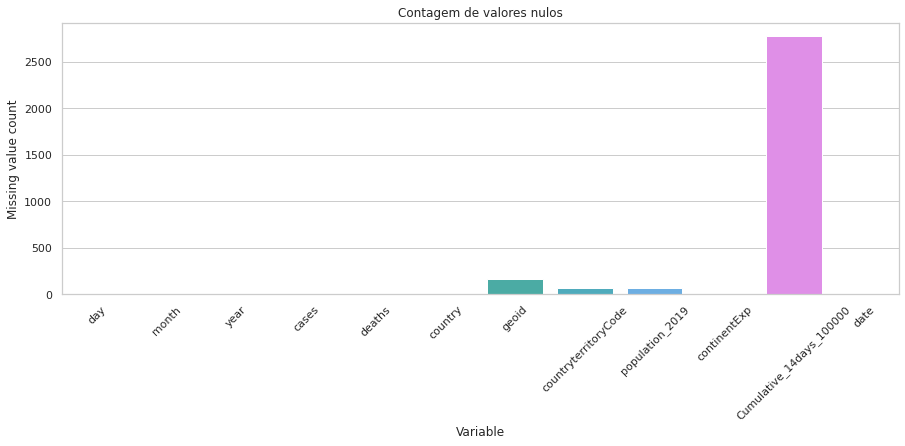

In [383]:
#Colocar aqui a análise dos NaNs
plt.figure(figsize=(15,5))
plt.title('Contagem de valores nulos')
missing = ecdc.isnull().sum().to_frame()
missing.columns = ['Missing value count']
missing.index.names = ['Variable']
missing['Variable'] = missing.index
sns.set(style='whitegrid', color_codes=True)
graph = sns.barplot(x='Variable', y='Missing value count', data=missing, orient='v')
#graph.set_xticklabels(labels=missing.columns, rotation=45)
for item in graph.get_xticklabels():
    item.set_rotation(45)

Há valores nulos nas variáveis geoId, countryterritoryCode, population_2019 e Cumulative_14days_100000. Os atributos geoId e countryterritoryCode podem ser ignorados, dado que parecem não acrescentar informação àquela já presente na coluna Country para os propósitos deste trabalho. 

Population e cumulative, no entanto, exigem uma estratégia de imputação. 

In [385]:
ecdc[['country','Cumulative_14days_100000','population_2019']]

Variable,country,Cumulative_14days_100000,population_2019
index,,,
1,Afghanistan,NaN,38041757.0
2,Algeria,NaN,43053054.0
3,Armenia,NaN,2957728.0
4,Australia,NaN,25203200.0
5,Austria,NaN,8858775.0
...,...,...,...
39325,Vietnam,0.111961,96462108.0
39326,Western_Sahara,0.000000,582458.0
39327,Yemen,0.291476,29161922.0


In [386]:
unique_population_counts_per_country = ecdc.groupby('country')[['population_2019']].nunique()
unique_df = unique_population_counts_per_country['population_2019'].value_counts().to_frame()
unique_df.columns = ['Contagem']
unique_df['Possui valor único de população para todos os registros'] = unique_df.index
unique_df

,Contagem,Possui valor único de população para todos os registros
1,209,1
0,1,0


O trecho acima revela que, dos 210 países na base, 209 possuem um único valor de população registrado para 2019. Em outras palavras, essa coluna replica o mesmo valor para todos os registros de cada país. 

In [387]:
print('Países que tem população nula: ', ecdc[ecdc['population_2019'].isnull()]['country'].unique())

Países que tem população nula:  ['Cases_on_an_international_conveyance_Japan']


Conclui-se ainda que o único tipo de registro que tem população nula são os que tem como país "Cases_on_an_international_conveyance_Japan". Dependendo do número de registros com este valor na variável país, pode ser possível ignorá-los.

In [389]:
counts = ecdc.groupby('country').count()['day']
counts.columns = ['Contagem de registros']
print("Número de registros com 'Cases on an international conveyance japan' como país: ", counts['Cases_on_an_international_conveyance_Japan'])

Número de registros com 'Cases on an international conveyance japan' como país:  64


Como há apenas 64 registros com este país, eles serão ignorados.

In [421]:
ecdc = ecdc[ecdc['country'] != 'Cases_on_an_international_conveyance_Japan']
cumulative_null = ecdc[ecdc['Cumulative_14days_100000'].isnull()]
cumulative_null = cumulative_null.set_index('country')
cumulative_null = cumulative_null.sort_index()
print('Número de registros que tem a variável "Cumulative_14days_100000" nula para cada país:', cumulative_null.index.value_counts().value_counts())
#Explicar o que está acontecendo com os nulos do cumulative

Número de registros que tem a variável "Cumulative_14days_100000" nula para cada país: 13    209
Name: country, dtype: int64


In [418]:
cumulative_not_null = ecdc[ecdc['Cumulative_14days_100000'].notnull()]
cumulative_not_null = cumulative_not_null.set_index('country')
cumulative_not_null = cumulative_not_null.sort_index()
cumulative_not_null.index.value_counts()


Taiwan                      230
United_States_of_America    230
Canada                      230
Japan                       230
Singapore                   230
                           ... 
Yemen                       129
Western_Sahara              113
Tajikistan                  108
Comoros                     107
Lesotho                      94
Name: country, Length: 209, dtype: int64

Nota-se que todos os países tem 13 registros em que a variável "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000". Isto faz sentido, dado que a primeira coleta deste atributo ocorre após o décimo quarto dia. Se essa variável for utilizada no processo de modelagem, os 13 primeiros dias podem precisar omitidos.

Nota-se também que alguns países tem número menor de registros, indicando que a coleta de notificações começou mais tarde.

## Estatísticas descritivas e boxplots

In [146]:
numerical = ecdc[['cases','deaths','population_2019','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']]
numerical.describe()

,cases,deaths,population_2019,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
count,39329.000000,39329.000000,3.926500e+04,36548.000000
mean,629.770042,21.296728,4.356086e+07,29.829640
std,3903.835228,125.518698,1.595846e+08,70.744754
min,0.000000,-1918.000000,8.150000e+02,-134.388021
25%,0.000000,0.000000,1.394969e+06,0.288427
50%,8.000000,0.000000,8.519373e+06,3.909339
75%,131.000000,2.000000,2.916192e+07,22.858351
max,78427.000000,4928.000000,1.433784e+09,1058.225943


Acima, são exibidas as estatísticas descritivas das variáveis numéricas. Abaixo, os boxplots indicando a dispersão de cada variável:

Text(0, 0.5, 'Total')

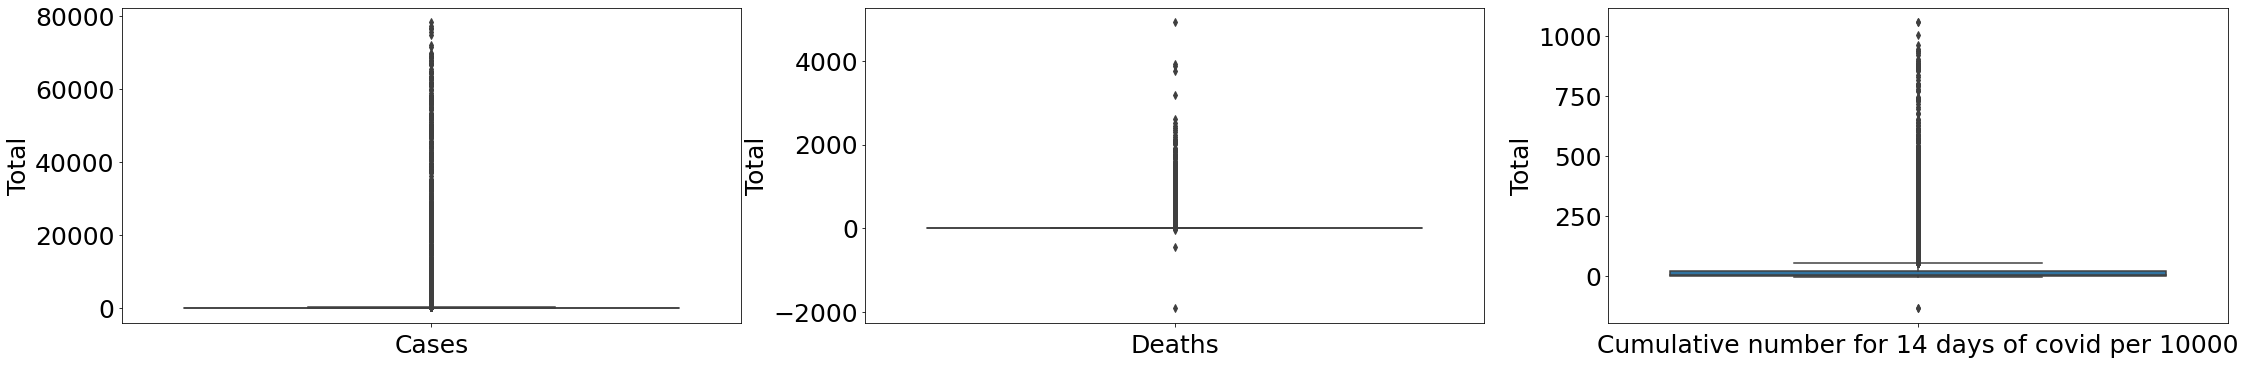

In [191]:
fig, axis = plt.subplots(1,3, figsize=(6,5))
plt.subplots_adjust(top=1, right=5)
plt.rcParams.update({'font.size': 25})

sns.boxplot(ecdc[['cases']], ax=axis[0], orient='v')
axis[0].set_xlabel('Cases')
axis[0].set_ylabel('Total')

sns.boxplot(ecdc[['deaths']], ax=axis[1], orient='v')
axis[1].set_xlabel('Deaths')
axis[1].set_ylabel('Total')

sns.boxplot(ecdc[['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']], ax=axis[2], orient='v')
axis[2].set_xlabel('Cumulative number for 14 days of covid per 10000')
axis[2].set_ylabel('Total')

O número de médio de casos reportados é 629.77, mas nota-se o valor observado para o desvio padrão, 3903.83,  aproximadamente 6 vezes maior do que a média. O mínimo é 0 enquanto o máximo é de 78427, e o valor 8 observado para a mediana indica que a metade inferior das contagens está concentrada em um intervalo estreito de valores, conforme pode ser observado no boxplot. A distância entre o segundo e o terceiro quartil é de 123, indicando uma maior dispersão dos valores. Já a distância do terceiro quartil para o máximo é de 78296, indicando uma variabilidade ainda maior entre as mais altas contagens.

O número de mortes exibe uma peculiaridade no valor mínimo, mostrando um valor negativo  que precisa ser analisado. Os primeiros 3 quartis são praticamente iguais, dado que a distacia entre o primeiro e o terceiro quartis é de apenas 2. O terceiro para o quarto quartil, assim como no número de casos, tem a maior variabilidade. 

O mesmo padrão de valores baixos estarem concentrados em uma faixa pequena, ao mesmo tempo em que há grande variabilidade em valores altos, pode ser observado no valor cumulativo.

In [51]:
ecdc['date'] = pd.to_datetime(ecdc[['day','month','year']], dayfirst=True)
print(ecdc['date'].min())
print(ecdc['date'].max())

2019-12-31 00:00:00
2020-08-29 00:00:00


A base contém dados coletados de 31/12/2019 até 29/08/2020, que também é o dia em que foi feito o acesso e download dos dados.

In [55]:
len(pd.unique(ecdc['country']))

210

A contagem de países únicos é 210. Esperava-se 195, indicando a necessidade de uma investigação para identificar a origem da disparidade.

In [60]:
print([pd.unique(ecdc['country'])])

[array(['Afghanistan', 'Algeria', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Belarus', 'Belgium', 'Brazil',
       'Cambodia', 'Canada', 'Cases_on_an_international_conveyance_Japan',
       'China', 'Croatia', 'Czechia', 'Denmark', 'Dominican_Republic',
       'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Lebanon',
       'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Monaco', 'Nepal',
       'Netherlands', 'New_Zealand', 'Nigeria', 'North_Macedonia',
       'Norway', 'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Romania',
       'Russia', 'San_Marino', 'Singapore', 'South_Korea', 'Spain',
       'Sri_Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand',
       'United_Arab_Emirates', 'United_Kingdom',
       'United_States_of_America', 'Vietnam', 'Andorra', 'Jordan',
       'Latvia', 'Morocco', 'Portugal', 'S

Observa-se que, apesar do nome da coluna, não há apenas registros de países na base. Há também presença de territórios autônomos e ultramarinos como Gibraltar, Ilhas Virgens Britânicas, Anguilla e as Ilhas Falkland. Além disso, a lista também exibe territórios disputados como Saara Ocidental e Kosovo, além de ter duas entrada relativas ao Japão. Essas são, portanto, as razões para a coluna countries ter 210 valores.